# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow those simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 4th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

In the exercises below, I describe the exercises in a general way. Drawing in the right parts of the exercises is part of the assignment. (That way we're helping you get a little bit more ready for the Final Project, where you have to decide what information to include in your report and analysis).


# Part 0: Common Code and "Less Relevant" Code
This part contains code which is necessary for the code the function, but not so interesting for our report.
Here we import the necessary packages.

In [49]:
import networkx as nx
import pickle
import requests
from io import BytesIO
import re
import html
from collections import Counter
import math
import numpy as np
import matplotlib.pyplot as plt
import wordcloud

- This is probably not the most intuitive way to get the wikitext, but from the graph we can easily retrieve the name of the Wiki-pages.

In [50]:
url = 'https://raw.githubusercontent.com/hoboldi/Social-Graphs-and-Interactions/main/Misc/MusicianGraph.pickle'
r = requests.get(url)
r.raise_for_status()

G = pickle.load(BytesIO(r.content))
print(G)

DiGraph with 481 nodes and 6491 edges


## Tokenizing the Wikipedia pages of the rock musicians.
- Based on the names of the nodes, we retrieve the Wiki-pages.
- We also save these Wiki-pages for convenience as the many calls to the website can take a long time, so for the convenience of the grader we pickled them.

In [85]:
# Get the name of the artists
artists = list(G.nodes())
print(artists[:10])

# Define API and HEADERS
API = "https://en.wikipedia.org/w/api.php"
HEADERS = {"User-Agent": "MyWikipediaClient/1.0 (example@example.com)"}

# This method is based on this: https://stackoverflow.com/a/62225015 and this line was partly done with ChatGPT data["query"]["pages"][0]["revisions"][0]["slots"]["main"]["content"].
def get_wikitext(title: str) -> str:
    params = {
        "action": "query",
        "prop": "revisions",
        "titles": title,
        "rvslots": "main",
        "rvprop": "content",
        "format": "json",
        "formatversion": "2",
    }

    response = requests.get(API, params=params, headers=HEADERS, timeout=20)
    response.raise_for_status()

    data = response.json()

    return data["query"]["pages"][0]["revisions"][0]["slots"]["main"]["content"]

artist_pages = {}

for artist in artists:
    artist_pages[artist] = get_wikitext(artist)

with open('Misc/ArtistPages.pickle', 'wb') as f:
    pickle.dump(artist_pages, f)

print(list(artist_pages.values())[0][:10])

['Funkadelic', 'Parliament-Funkadelic', 'Jimi_Hendrix', 'Sly_and_the_Family_Stone', 'Cream_(band)|Cream', 'Slayer', 'Metallica', 'Megadeth', 'Anthrax_(American_band)|Anthrax', 'Iron_Maiden']
{{short de


- To avoid the long runtime, with this we can load the ArtistPages faster. (This still takes a good 30s, but much better than the 5m of the other version.)

In [76]:
url = "https://raw.githubusercontent.com/hoboldi/Social-Graphs-and-Interactions/main/Misc/ArtistPages.pickle"
artist_pages = pickle.load(BytesIO(requests.get(url).content))

print(list(artist_pages.values())[0][:10])

{{short de


## Tokenizing the texts
- In this part we convert the raw wikitext to tokenized version.
- This part (as recommended) was done with the help of ChatGPT.

In [87]:
# In this part we define some regular expressions for filtering out specific wikitext (and html) elements.

# Filter out comments.
RE_COMMENTS   = re.compile(r'<!--.*?-->', flags=re.DOTALL)
# Filter out citations (refs).
RE_REF_TAGS   = re.compile(r'<ref[^>]*>.*?</ref>|<ref[^>]*/>', flags=re.DOTALL|re.IGNORECASE)
# Filter out HTML tags.
RE_HTML_TAGS  = re.compile(r'</?[^>]+?>', flags=re.DOTALL)
# Filter out non-nested templates. (flag moved to flags=...)
RE_TEMPLATES  = re.compile(r'\{\{[^{}]*\}\}', flags=re.DOTALL)
# Filter out tables.
RE_TABLES     = re.compile(r'\{\|.*?\|\}', flags=re.DOTALL)
# Filter out file tags.
RE_FILES      = re.compile(r'\[\[(?:File|Image):[^\]]+\]\]', flags=re.IGNORECASE)
# Filter out external links.
RE_EXTLINKS   = re.compile(r'\[(?:https?://|ftp://)[^\s\]]+(?:\s+[^\]]+)?\]')
# Filter out internal links.
RE_LINKS      = re.compile(r'\[\[([^[\]|#]+)(?:#[^\]|]+)?(?:\|([^\]]+))?\]\]')
# Filter out headings.
RE_HEADING    = re.compile(r'^\s*=+[^=\n]+?=+\s*$', flags=re.MULTILINE)
# Filter out formatting.
RE_FORMATTING = re.compile(r"'''+|''")
# Filter out list/definition prefixes.
RE_LIST_BUL   = re.compile(r'^[*#;:]+', flags=re.MULTILINE)
# Filter out remaining parts of tables.
RE_TABLE_ROWS = re.compile(r'^\s*\|\+.*$|^\s*\|[-!].*$', flags=re.MULTILINE)
# Filter out raw urls.
RE_URLS       = re.compile(r'(?:https?://|ftp://)\S+')
# Filter out HTML entities.
RE_ENTITY     = re.compile(r'&[A-Za-z#0-9]+;')

# A lambda expression to split a text into words.
WORD_SPLIT = lambda s: re.findall(r'[A-Za-z]+', s)

# This function removes nested "{{...}}" templates by applying regex until nothing changes.
def _strip_templates(text: str) -> str:
    prev = None
    while prev != text:
        prev = text
        text = RE_TEMPLATES.sub('', text)
    return text

# This function converts a wikitext into simple text.
def wikitext_to_words(text: str, lower: bool = True) -> list[str]:
    if not text:
        return []

    if lower:
        text = text.casefold()

    # Apply the previously defined regexes.
    text = RE_COMMENTS.sub(' ', text)
    text = RE_REF_TAGS.sub(' ', text)
    text = RE_TABLES.sub(' ', text)
    text = _strip_templates(text)
    text = RE_FILES.sub(' ', text)
    text = RE_EXTLINKS.sub(' ', text)
    text = RE_HTML_TAGS.sub(' ', text)

    # Remove the text of links.
    def _keep_link(m):
        target, disp = m.group(1), m.group(2)
        return disp if disp else target
    text = RE_LINKS.sub(_keep_link, text)

    # Apply another batch of previously defined filters.
    text = RE_HEADING.sub(' ', text)
    text = RE_LIST_BUL.sub(' ', text)
    text = RE_TABLE_ROWS.sub(' ', text)
    text = RE_FORMATTING.sub(' ', text)
    text = RE_URLS.sub(' ', text)
    text = RE_ENTITY.sub(lambda m: html.unescape(m.group(0)), text)

    # Collapse whitespace.
    text = ' '.join(text.split())

    words = WORD_SPLIT(text)
    if lower:
        words = [w.lower() for w in words]

    return words

- Applying the preprocessing function to our wikitext pages.

In [88]:
text_pages = {artist: wikitext_to_words(page) for artist, page in artist_pages.items()}

print(list(text_pages.values())[0][:20])

['funkadelic', 'was', 'an', 'american', 'funk', 'rock', 'funkadelic', 'initially', 'formed', 'as', 'a', 'backing', 'band', 'for', 'clinton', 's', 'vocal', 'group', 'the', 'parliaments']


- After we tokenized the text we can sum the counts.

In [89]:
tokenized_pages = {artist: Counter(text) for artist, text in text_pages.items()}

print(list(tokenized_pages.values())[0].most_common(20))

[('the', 109), ('and', 57), ('of', 49), ('in', 45), ('funkadelic', 37), ('a', 37), ('s', 30), ('funk', 26), ('album', 23), ('was', 21), ('on', 19), ('as', 18), ('clinton', 18), ('by', 18), ('to', 17), ('parliament', 15), ('category', 15), ('groups', 13), ('rock', 12), ('band', 12)]


- **Q:** Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1).

In [91]:
# We have uploaded the Wordlist to our GitHub repository for easier access.
url = "https://raw.githubusercontent.com/hoboldi/Social-Graphs-and-Interactions/main/Misc/Sentiment_Data.txt"
wordlist = requests.get(url).text

# Print the first few characters.
print(wordlist[:53])

# Remove the first few lines, which are not actually relevant information for the dictionary.
lines = wordlist.splitlines()[3:]

# Creating the dictionary.
labmt = {}
for ln in wordlist.splitlines():
    ln = ln.strip()
    if not ln or ln.startswith('#') or ln.startswith('word'):
        continue
    parts = ln.split()
    if len(parts) < 3:
        continue
    w = parts[0].lower()
    try:
        avg = float(parts[2])
    except ValueError:
        continue
    labmt[w] = avg

print(list(labmt.items())[:10])

labMIT-1.0.txt
language assessment by Mechanical Turk
[('laughter', 8.5), ('happiness', 8.44), ('love', 8.42), ('happy', 8.3), ('laughed', 8.26), ('laugh', 8.22), ('laughing', 8.2), ('excellent', 8.18), ('laughs', 8.18), ('joy', 8.16)]


## Extracting the Communities

In [109]:
# Extract the Louvain communities
Communities = nx.community.louvain_communities(G, seed=123, resolution=2.5)

# Extracting the 10 largest communities
top10 = sorted(Communities, key=len, reverse=True)[:10]

# Nodes to keep
Communities = set().union(*top10)

# Part 1: Analyze the network

The questions in this part are based on Lecture 5.

* Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
   - It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
   - I would like you to include concepts like centrality and assortativity in your analysis.
   - Use a network backbone in your analysis.
   - In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
   - **Note**: As I write above, an important part of the exercise consists is *selecting the right elements of the lecture* to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network.

# Part 2: Genres and communities and plotting

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.

In [ ]:
# This part of the week 7 exercise was completed by using LLM.
# Just looked over the results and test cases to make sure it is working as intended.


# Regex helpers
REF_TAG_RE = re.compile(r"<ref[^>]*>.*?</ref>", flags=re.IGNORECASE | re.DOTALL)
HTML_TAG_RE = re.compile(r"<[^>]+>")
WIKI_REF_RE = re.compile(r"\[\d+\]")
WIKI_LINK_RE = re.compile(r"\[\[([^|\]]+)\|?([^\]]+)?\]\]")  # [[target|label]] or [[label]]
MULTISPACE_RE = re.compile(r"\s+")
BR_RE = re.compile(r"(<br\s*/?>|•|·|&nbsp;)", flags=re.IGNORECASE)

# Delimiters for list splitting (note: we deliberately DO NOT split on '&' or 'and')
SPLIT_DELIMS = re.compile(
    r"\s*(?:,|;|/|\\|\+|\||<br\s*/?>|[\r\n]+)\s*",
    flags=re.IGNORECASE
)

LIST_TEMPLATES = {"hlist", "flatlist", "plainlist", "ubl"}


# Low-level cleaners
def html_unescape(text: str) -> str:
    replacements = {
        "&amp;": "&",
        "&nbsp;": " ",
        "&quot;": '"',
        "&#39;": "'",
        "&apos;": "'",
        "&lt;": "<",
        "&gt;": ">",
    }
    for k, v in replacements.items():
        text = text.replace(k, v)
    return text

def strip_refs_and_tags(text: str) -> str:
    text = REF_TAG_RE.sub(" ", text)      # remove <ref>…</ref>
    text = WIKI_REF_RE.sub(" ", text)     # remove [1], [2]
    text = BR_RE.sub(" | ", text)         # keep a visible list delimiter
    text = HTML_TAG_RE.sub(" ", text)     # remove HTML tags
    text = MULTISPACE_RE.sub(" ", text)
    return text.strip()

def replace_wiki_links(text: str) -> str:
    def repl(m):
        target = m.group(1)
        label = m.group(2)
        return (label or target)
    return WIKI_LINK_RE.sub(repl, text)

def expand_and_strip_templates(s: str) -> str:
    out = []
    i = 0
    n = len(s)
    while i < n:
        if i + 1 < n and s[i] == "{" and s[i+1] == "{":
            # capture template with balancing
            depth = 0
            j = i
            while j < n:
                if j + 1 < n and s[j] == "{" and s[j+1] == "{":
                    depth += 1
                    j += 2
                    continue
                if j + 1 < n and s[j] == "}" and s[j+1] == "}":
                    depth -= 1
                    j += 2
                    if depth == 0:
                        break
                    continue
                j += 1
            body = s[i+2:j-2] if j-2 >= i+2 else ""
            parts = body.split("|")
            name = parts[0].strip().lower() if parts else ""
            params = [p.strip() for p in parts[1:]]
            if name in LIST_TEMPLATES:
                items = []
                for p in params:
                    if "=" in p:
                        continue
                    if p:
                        items.append(p)
                out.append(" | ".join(items))
            i = j
            continue
        else:
            out.append(s[i])
            i += 1
    return "".join(out)


# Lowercasing all genres and mapping genres with different names into one
def normalize_genre_token(g: str) -> Optional[str]:
    if not g:
        return None
    g = g.strip().lower()
    if not g:
        return None

    g = g.replace("’", "'").replace("´", "'").replace("`", "'")
    g = g.replace("–", "-").replace("—", "-")

    if g in {
        "rock 'n' roll", "rock n roll", "rock & roll", "rock’n’roll",
        "rock'n'roll", "rock-and-roll", "rock and roll"
    }:
        g = "rock and roll"

    replacements = {
        "r&b": "rhythm and blues",
        "rnb": "rhythm and blues",
        "hip hop": "hip-hop",
    }
    if g in replacements:
        g = replacements[g]

    g = re.sub(r"\s*\(.*?\)\s*$", "", g).strip()
    g = MULTISPACE_RE.sub(" ", g)

    # filter junk
    if not g or g in {"genre", "genres"}:
        return None
    if g.startswith(("http:", "https:", "www.")):
        return None
    if len(g) == 1:
        return None
    return g

# Tokenization pipeline
def tokenize_genres(raw: str) -> List[str]:
    raw = expand_and_strip_templates(raw)
    raw = replace_wiki_links(raw)
    raw = strip_refs_and_tags(raw)
    raw = html_unescape(raw)

    tokens = [t.strip() for t in SPLIT_DELIMS.split(raw) if t.strip()]
    out: List[str] = []
    for t in tokens:
        t = re.sub(r"^\s*(?:genre|genres)\s*[:=]\s*", "", t, flags=re.IGNORECASE).strip()
        # Clean stray braces from partial template remains
        t = t.strip(" {}[]")
        nt = normalize_genre_token(t)
        if nt:
            out.append(nt)
    return out


INFOBOX_START_RE = re.compile(
    r"\{\{\s*Infobox\s+musical\s+(?:artist|group|band)",
    flags=re.IGNORECASE
)

def extract_infobox_wikitext(text: str) -> Optional[str]:
    m = INFOBOX_START_RE.search(text)
    if not m:
        return None
    i = m.start()
    # Balance braces to capture full template
    depth = 0
    j = i
    L = len(text)
    while j < L:
        if j + 1 < L and text[j] == "{" and text[j+1] == "{":
            depth += 1
            j += 2
            continue
        if j + 1 < L and text[j] == "}" and text[j+1] == "}":
            depth -= 1
            j += 2
            if depth == 0:
                return text[i:j]
            continue
        j += 1
    return None

def get_genre_field_from_wikitext(infobox: str) -> Optional[str]:
    lines = infobox.splitlines()
    buf = []
    capturing = False
    for ln in lines:
        if re.match(r"\s*\|\s*(genre|genres)\s*=", ln, flags=re.IGNORECASE):
            capturing = True
            rhs = ln.split("=", 1)[1]
            if "}}" in rhs:
                rhs = rhs.split("}}", 1)[0]
                buf.append(rhs)
                break
            buf.append(rhs)
        elif capturing:
            if re.match(r"\s*\|\s*[a-zA-Z_]+\s*=", ln):
                break
            if "}}" in ln:
                ln = ln.split("}}", 1)[0]
                if ln.strip():
                    buf.append(ln)
                break
            buf.append(ln)
    if not buf:
        return None
    raw = "\n".join(buf)
    return raw.strip() or None


def extract_genres_from_page(text: str) -> List[str]:
    infobox = extract_infobox_wikitext(text)
    if not infobox:
        return []  # no infobox, ignore node

    raw = get_genre_field_from_wikitext(infobox)
    if not raw:
        return []  # infobox present, but no genre field

    raw = re.sub(r"\[(?:https?|ftp)://[^\]\s]+(?:\s+[^\]]+)?\]", " ", raw, flags=re.IGNORECASE)
    raw = re.sub(r"(?:https?|ftp)://\S+", " ", raw, flags=re.IGNORECASE)
    raw = re.sub(r"\bwww\.[^\s\]]+", " ", raw, flags=re.IGNORECASE)

    genres = tokenize_genres(raw)

    seen = set()
    uniq = []
    for g in genres:
        if g not in seen:
            seen.add(g)
            uniq.append(g)
    return uniq

def build_genres_from_pages(pages: Dict[str, str]) -> Dict[str, List[str]]:
    out: Dict[str, List[str]] = {}
    for artist, text in pages.items():
        genres = extract_genres_from_page(text)
        if genres:
            out[artist] = genres
    return out


# Adding genre to node
def attach_genres_to_graph(G: nx.DiGraph, artist_to_genres: Dict[str, List[str]]) -> None:
    # Attach for those we found
    for artist, genres in artist_to_genres.items():
        if artist in G and genres:
            G.nodes[artist]["genres"] = genres
    # Remove stale/empty
    for node, data in list(G.nodes(data=True)):
        if "genres" in data and (node not in artist_to_genres or not artist_to_genres.get(node)):
            del G.nodes[node]["genres"]


def compute_stats_from_graph(G: nx.DiGraph) -> Tuple[int, float, int, Counter]:
    nodes_with = {n: d["genres"] for n, d in G.nodes(data=True) if "genres" in d and d["genres"]}
    n_nodes = len(nodes_with)
    if n_nodes == 0:
        return 0, 0.0, 0, Counter()
    avg = sum(len(v) for v in nodes_with.values()) / n_nodes
    all_genres = [g for gs in nodes_with.values() for g in gs]
    distinct = len(set(all_genres))
    counter = Counter(all_genres)
    return n_nodes, avg, distinct, counter


def _test_cases():
    tests = [
        # Simple case: single genre in infobox
        ("Simple genre",
         """{{Infobox musical artist
| name = Example Artist
| genre = [[Rock music|Rock]]
}}""",
         {"rock"}),

        # Multiple genres separated by refs and line breaks
        ("The Rolling Stones (wikitext)",
         """{{Infobox musical artist
| name = The Rolling Stones
| origin = London, England
| genre = [[Rock and roll|rock 'n' roll]]<ref></ref><br/>[[Blues]]; [[Pop music|pop]]
| years_active = 1962–present
}}""",
         {"rock and roll", "blues", "pop"}),

        # hlist template (common in Wikipedia infoboxes)
        ("The Animals (hlist)",
         """{{Infobox musical group
| name = The Animals
| genres = {{hlist|[[Rock music|Rock]]|[[Rhythm and blues|R&B]]|[[Blues rock]]}}
}}""",
         {"rock", "rhythm and blues", "blues rock"}),

        # No genre field at all → should return empty set
        ("No genre",
         """{{Infobox musical artist
| name = Unknown Artist
| years_active = 1990–present
}}""",
         set()),

        # Weird punctuation and synonyms
        ("Synonym cleanup",
         """{{Infobox musical artist
| genre = [[Hip hop]] / [[R&B]]
}}""",
         {"hip-hop", "rhythm and blues"}),

        # Edge case: junk genre field
        ("Junk field",
         """{{Infobox musical artist
| genre = [http://example.com SomeLink] genre
}}""",
         set())
    ]

    for name, text, expected in tests:
        got = set(extract_genres_from_page(text))
        assert got == expected, f"{name}: expected {expected}, got {got}"
    print("All tests passed")


if __name__ == "__main__":
    _test_cases()

    artist_to_genres = build_genres_from_pages(artist_pages)

    attach_genres_to_graph(G, artist_to_genres)

    n_nodes_with_genres, avg_genres, n_distinct, counter = compute_stats_from_graph(G)
    print("\n=== Genre Extraction Stats (nodes with a 'genres' attribute) ===")
    print(f"Nodes with genres: {n_nodes_with_genres}")
    print(f"Average genres per node: {avg_genres:.3f}")
    print(f"Total distinct genres: {n_distinct}")

    print("\nTop 15 genres:")
    for genre, cnt in counter.most_common(15):
        print(f"{genre:25s} {cnt}")

In [ ]:
nodes_with_genres = [n for n, d in G.nodes(data=True) if d.get("genres")]
H = G.subgraph(nodes_with_genres).to_undirected().copy()

genre_partition = defaultdict(set)

for n, d in H.nodes(data=True):
    first_genre = d["genres"][0]
    genre_partition[first_genre].add(n)

# Convert to list of sets (format expected by NetworkX modularity function)
communities = list(genre_partition.values())

# calculating modularity
L = H.number_of_edges()
M = 0

for community_nodes in communities:
    L_c = H.subgraph(community_nodes).number_of_edges() #nr of edges in this community
    k_c = sum(dict(H.degree(community_nodes)).values())  #sum of degrees of all nodes in community
    M += (L_c / L) - ( (k_c / (2*L))**2 )

print("The modularity of genre partion is ", M)

- Detecting the communitites and calculating the modularity

In [ ]:
# Using the same Louvain algorithm on our undirected graph H
partition = community_louvain.best_partition(H)

modularity_value = community_louvain.modularity(partition, H)
print(f"Modularity of Louvain partition: {modularity_value:.4f}")

### Communities value of modularity in comparison to the genres

Genre-based community grouping showed modularity of **0.0125**, which is pretty low and shows that the grouping by genre doesn't align well with the actual network structure. There is very little correlation between artist's genres and how they connect in the network so - artists of the same genre don't necessarily link more often than random pairs.

Louvain aka structural communities shows a modularity score of **0.3345**, which can be considered moderate, meaning there are meaningful clusters. The groups of nodes are densely connected internally and sparsely connected between groups.

In conclusion the network is much more **community-like** structurally than it is genre-like.

- Calculate the matrix D and discuss your findings

In [ ]:
all_genres = [g for _, d in H.nodes(data=True) for g in d.get("genres", [])]
genre_counts = Counter(all_genres)
top_genres = [g for g, _ in genre_counts.most_common(7)]

community_counts = Counter(partition.values())

# nice column labels with sizes
col_labels = [f"C{c} (n={community_counts[c]})" for c in community_counts]

# 2) build confusion (counts)
confusion = pd.DataFrame(0, index=top_genres, columns=community_counts, dtype=int)

for n, d in H.nodes(data=True):
    cid = partition.get(n)
    if cid not in top_comms:
        continue
    for g in d.get("genres", []):
        if g in top_genres:
            confusion.loc[g, cid] += 1

confusion_df = confusion.copy()
confusion_df.columns = col_labels

print("Confusion matrix (counts):")
print(confusion_df)

# 4) normalized views
row_norm = confusion_df.div(confusion_df.sum(axis=1).replace(0, 1), axis=0)
col_norm = confusion_df.div(confusion_df.sum(axis=0).replace(0, 1), axis=1)

print("\nRow-normalized (per-genre distribution across communities):")
print(row_norm.round(3))

print("\nColumn-normalized (per-community genre mix):")
print(col_norm.round(3))

For our network we have six communities,
The confusion matrix describes the six largest communities to the seven most common genres.
The largest communitites are C0, C5, C1 and C3, which correspong to major stylistic groupings. C0 is dominated by **rock** and **pop**, C5 by **alternative rock**, C1 by **heavy metal** and C3 mostly by **hard rock** and **alternative rock**. However, there is also some overlap between genres, indicating that the network's communities are not perfectly genre-homogeneous.
Since C4 has one node, it don't include any artist within the seven most common genres.
- Plot the communities

In [ ]:
# Only coloring the 8 largest communities, while leaving others grey
K = 8
comm_sizes = Counter(partition.values())
top_comms = {cid for cid, _ in comm_sizes.most_common(K)}

cmap = plt.colormaps.get_cmap("tab20")
cid2color = {cid: cmap(i / K) for i, cid in enumerate(sorted(top_comms))}

# Assign color per node
node_colors = [
    cid2color.get(partition[n], (0.8, 0.8, 0.8, 0.3))
    for n in H.nodes()
]


# Visualizing the network using the Force Atlas algorithm
pos = nx.forceatlas2_layout(
    H,
    max_iter=2000,
    linlog=True,
    scaling_ratio=70.0,
    gravity=1,
    strong_gravity=False,
    jitter_tolerance=1.0,
    seed=42
)

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(H, pos, alpha=0.15, width=0.4)
nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=25, linewidths=0)

plt.title(f"Louvain communities\nModularity={modularity_value:.3f}", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()

# Part 3: TF-IDF to understand genres and communities

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to discuss the difference between the word-clouds between genres and communities.


**TF** stands for **term frequency**, showing how many times a word shows up in a document. But if we only look at the tf, then we don't actually see the words that make the document special, we just see the words that are used the most.

**IDF** stands for **inverse document frequency** and it measures how **rare** a word is across all documents. If a word occurs in many documents, then it isn't that special and the IDF is small, but if it appears less, then it is more rare and it actually says something about the document. Instead of looking at one document, it looks at the whole library of documents (in ourcase all the wikipedia pages about rock bands) to see what is actually special and meaningful, and what not.

In this context the TF-IDF describes the genres - from the wordclouds we can see that a lot of the times, the words that show up are either band names or words that describe the type of genre (like 'guitar').

- Calculate and visualize TF-IDF for the genres and communities.
We will find the TF-IDF for the top 15 genres and since artists have multiple genres listed, we are only looking the first genre listed.



In [ ]:
# Used ChatGPT the cleaning and normalizing of the wikipages

REF_TAG_RE   = re.compile(r"<ref[^>]*>.*?</ref>", flags=re.IGNORECASE|re.DOTALL)
CITE_TPL_RE  = re.compile(r"\{\{\s*cite[^}]*\}\}", flags=re.IGNORECASE|re.DOTALL)
NUMREF_RE    = re.compile(r"\[\d+\]")  # [1], [2], ...
HTML_TAG_RE  = re.compile(r"<[^>]+>")
WIKILINK_RE  = re.compile(r"\[\[([^|\]]+)\|?([^\]]+)?\]\]")
MULTISPACE   = re.compile(r"\s+")

def clean_wiki_text(text: str) -> str:
    # remove citations & tags before tokenizing
    text = REF_TAG_RE.sub(" ", text)
    text = CITE_TPL_RE.sub(" ", text)
    text = NUMREF_RE.sub(" ", text)
    text = HTML_TAG_RE.sub(" ", text)
    text = WIKILINK_RE.sub(lambda m: (m.group(2) or m.group(1)), text)  # keep label
    text = MULTISPACE.sub(" ", text)
    return text

DELIMS = re.compile(r"\s*(?:[,;/|]|<br\s*/?>|\*|•|·|\band\b)\s*", flags=re.IGNORECASE)

def normalize_genre_label(g: str) -> str:
    g = g.strip().lower()
    if not g: return ""
    # resolve wikilinks if any
    g = WIKILINK_RE.sub(lambda m: (m.group(2) or m.group(1)), g)
    # strip bullets/asterisks and stray punctuation
    g = g.strip(" *•·-–—")
    # if someone dumped multiple genres in one string, split and take the first clean piece
    g = DELIMS.split(g)[0].strip()
    # unify rock & roll variants
    g = re.sub(r"rock\s*(?:&|and|(?:'?\s*n\s*'?)|’n’|-and-)\s*roll", "rock and roll", g, flags=re.IGNORECASE)
    return g

word_pattern = re.compile(r"\b[\w'-]+\b", flags=re.UNICODE)
stops = set(stopwords.words("english"))

# removed some more stop words that are common in wikipedia
stops.update({"ref", "references", "retrieved", "archive", "archived", "url", "http", "https", "www", "com"})

def tokenize(text: str):
    return [w for w in word_pattern.findall(text.lower())
            if w not in stops and len(w) > 2 and not w.isdigit() and "http" not in w and "www" not in w]

genre_texts = collections.defaultdict(list)

for artist, raw in artist_pages.items():
    genres = (G.nodes.get(artist, {}).get("genres") or [])
    if not genres:
        continue
    first_genre = normalize_genre_label(genres[0])
    if not first_genre:
        continue

    text = clean_wiki_text(raw)
    words = tokenize(text)
    genre_texts[first_genre].extend(words)

# pick the 15 biggest genres by token count
top15_genres = sorted(genre_texts, key=lambda g: len(genre_texts[g]), reverse=True)[:15]

# make term freqency lists with rare-word filter (>=5)
tf_lists = {}
for g in top15_genres:
    cnt = collections.Counter(genre_texts[g])
    cnt = collections.Counter({w: c for w, c in cnt.items() if c >= 5})
    tf_lists[g] = cnt


N = len(tf_lists)
df = collections.Counter()  # document frequency for words across genres
for g, counter in tf_lists.items():
    for w in counter.keys():
        df[w] += 1

# The code uses natural log, since the base is not important for ranking (all IDF scores are just scaled by a constant)
idf = {word: math.log((N+1)/(df[word]+1)) for word in df}

tfidf_by_genre: dict[str, dict[str, float]] = {}

# generating wordclouds for each genre
for g, counter in tf_lists.items():
    total = sum(counter.values())
    if total == 0:
        continue
    tfidf_weights = {w: (c / total) * idf[w] for w, c in counter.items()}

    wc = WordCloud(width=800, height=400, background_color="white", collocations=False)
    wc.generate_from_frequencies(tfidf_weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"TF-IDF WordCloud — {g}", fontsize=16)
    plt.show()

# Part 4: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

## Part 4.1: Calculate the sentiment of the Artist Pages
We deemed that in Part 4, the exercises which are based on tokenization are not as important as these are mostly monotone and were arleady part of previous exercises.
However, as for the notebook and 'code' to work we still need to include the tokenization. These parts can be found in Part 0 of the Notebook.




- **Q:** Describe briefly how the list was generated.
- **A:** First, they composed a list of the most frequent words, these words were the combined list of most frequent words from Twitter, Google Books, Music Lyrics and the New York Times. Second, they used the crowdsourcing service of the Mechanical Turk where the users could vote on the "happiness of the word" based on a 1-9 scale where they could choose 1,3,5,7,9. The study avoided word preprocessings. The study als omitted completely neutral words like: "the", "and" or "of". This was done with removing words with a value near 5.

- **Q:** Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).


In [92]:
# The function which calculates the sentiment of a given list of tokens.
def sentiment(counts, labmt, delta=1.0):
    num = den = 0.0
    for w, c in counts.items():
        h = labmt.get(w)
        if h is None:
            continue

        # Removing "unimportant" words (very neutral words)
        if abs(h - 5.0) <= delta:
            continue

        num += c * h
        den += c

    return num / den if den > 0 else math.nan

print(sentiment(list(tokenized_pages.values())[0],labmt))

6.402550143266474


**Remark:** A close but slightly positive mean is very much expected, as Wikipedia is a very neutral source of text.

- **Q:** Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.
- **Remark:** The tokenization can be found in Part 0.

In [121]:
sentiments = {artist: sentiment(tokenized_page, labmt) for artist, tokenized_page in tokenized_pages.items()}

print(sorted(sentiments, key=lambda x: x[1], reverse=True)[:10])

nx.set_node_attributes(G, sentiments, name='sentiment')

['Mötley_Crüe', 'Ozzy_Osbourne', 'System_of_a_Down', 'My_Chemical_Romance', 'Lynyrd_Skynyrd', 'Extreme_(band)|Extreme', 'Twisted_Sister', 'Awolnation', 'Twenty_One_Pilots', 'Avenged_Sevenfold']


- **Q:** Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.


In [122]:
avg_sentiment = np.mean(list(sentiments.values()))
print(f"Average sentiment of the artists is: {avg_sentiment}")

median = np.median(list(sentiments.values()))
print(f"Median sentiment of the artists is: {median}")

variance = np.var(list(sentiments.values()))
print(f"Variance of the sentiments is: {variance}")

first_quartier = np.percentile(list(sentiments.values()),25)
print(f"The 25th percentile is: {first_quartier}")

third_quartier = np.percentile(list(sentiments.values()),75)
print(f"The 75th percentile is: {third_quartier}")

Average sentiment of the artists is: 6.271319757799702
Median sentiment of the artists is: 6.298012658227847
Variance of the sentiments is: 0.032082973369933314
The 25th percentile is: 6.209111791730478
The 75th percentile is: 6.372102941176477


**Remarks:** Under the histogram.

- **Q:** Remember histograms? Create a histogram of all of the artists's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.

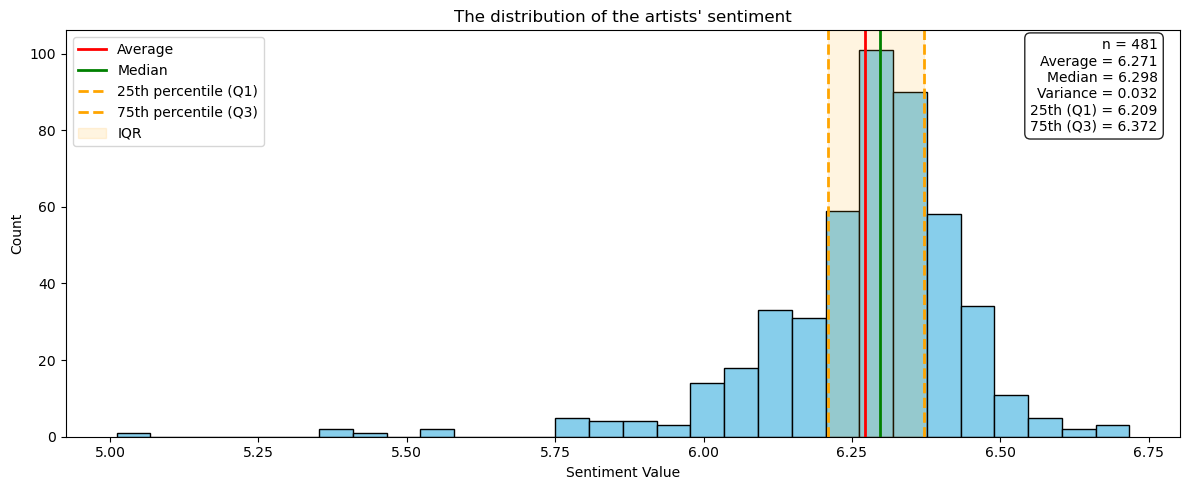

In [95]:
plt.figure(figsize=(12, 5))
plt.hist(sentiments.values(), bins=30, color="skyblue", edgecolor="black")
plt.title("The Distribution of the Artists' Sentiment")
plt.xlabel("Sentiment Value")
plt.ylabel("Count")

# lines + IQR band using your names
plt.axvline(avg_sentiment, color="red", linewidth=2, label="Average")
plt.axvline(median, color="green", linewidth=2, label="Median")
plt.axvline(first_quartier, color="orange", linestyle="--", linewidth=2, label="25th percentile (Q1)")
plt.axvline(third_quartier, color="orange", linestyle="--", linewidth=2, label="75th percentile (Q3)")
plt.axvspan(first_quartier, third_quartier, color="orange", alpha=0.12, label="IQR")

# stats box (shows your variable names/values)
stats_txt = (
    f"n = {len(sentiments.values())}\n"
    f"Average = {avg_sentiment:.3f}\n"
    f"Median = {median:.3f}\n"
    f"Variance = {variance:.3f}\n"
    f"25th (Q1) = {first_quartier:.3f}\n"
    f"75th (Q3) = {third_quartier:.3f}"
)
plt.text(
    0.98, 0.98, stats_txt,
    transform=plt.gca().transAxes, ha="right", va="top",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.85)
)

plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

**Image 4.1:
The Distribution of the Artists' Sentiment**

- X-axis is the sentiment value.
- Y-axis is the number of artist pages with the given sentiment value.

**Remarks:**
- The distribution follows a very normal-like distribution.
- The average and median values are both near each other.
- The variance is also relatively small.
- The pages are all a little positive, but not much.
- The interquartile range is also relative small.

- These observations all make sense, as Wikipedia is a very objective, factual website. Being close to a little positive, but still very much neutral mean is to be expected.
- Furthermore, as all pages should be factual and not biased, the fact that the variance, IQR are small also make sense. All variations should stem from the history of artists and not from the variations in the authorship's bias.


- **Q:** Who are the 10 artists with happiest and saddest pages?

In [96]:
lowest_10 = sorted(sentiments.items(), key=lambda x: x[1])[:10]

print("The 10 artists with the lowest sentiment values:")
for artist, value in lowest_10:
    print(f"{artist}: {value:.2f}")

print()

lowest_10 = sorted(sentiments.items(), key=lambda x: x[1])[-10:]

print("The 10 artists with the highest sentiment values:")
for artist, value in lowest_10:
    print(f"{artist}: {value:.2f}")

The 10 artists with the lowest sentiment values:
Poison_(American_band)|Poison: 5.01
Anthrax_(American_band)|Anthrax: 5.36
Sting_(musician)|Sting: 5.37
Ghost_(Swedish_band)|Ghost: 5.45
Traffic_(band)|Traffic: 5.53
Royal_Blood_(band)|Royal_Blood: 5.56
Saliva_(band)|Saliva: 5.76
Quiet_Riot: 5.78
Heart_(band)|Heart: 5.80
Rob_Zombie: 5.80

The 10 artists with the highest sentiment values:
Air_Supply: 6.57
Fun_(band)|Fun.: 6.59
Michael_Martin_Murphey: 6.60
Kiss_(band)|Kiss: 6.60
Lenny_Kravitz: 6.60
Bush_(British_band)|Bush: 6.61
Icehouse_(band)|Icehouse: 6.61
Cake_(band)|Cake: 6.69
Scorpions_(band)|Scorpions: 6.71
The_Boxtones: 6.72


**Remarks:**
- Although, this is only a hypothesis, we believe there is a correlation between the bands' sentiment and the bands' name.
- Maybe because the name of the band appears more often inside the articles.
- Artists like: Fun, Kiss, and, Cake  have high sentiments.
- Artists like: Saliva, Rob Zombie, Royal Blood, Traffic, Ghost, Poison and, Sting have low sentiments.
- The first list includes positive, the second negative words.
- Naturally this is not 100% rule, as 'Scorpions' or 'Heart' contradict this theory.

## Part 4.2: Community Sentiment Distribution
- **Q:** Name each community by its three most connected bands. (Or feed the list of bands in each community and ask the LLM to come up with a good name for the community).
- **Remark:** The calculation of the communities can be found in Part 0. As we deemed it is not important for our report.


In [110]:
most_connected_bands = {}

for i, comm in enumerate(top10):
    H = G.subgraph(comm)
    deg = H.degree()
    top = sorted(deg, key=lambda x: (x[1], str(x[0])), reverse=True)[:3]
    labels = [n for n, _ in top]
    most_connected_bands[i] = " • ".join(map(str, labels))

print(most_connected_bands)

{0: 'Bob_Dylan • Little_Richard • Elvis_Presley', 1: 'U2 • Coldplay • Roxy_Music', 2: 'Journey_(band)|Journey • Def_Leppard • REO_Speedwagon', 3: 'Green_Day • Blink-182 • Weezer', 4: 'Breaking_Benjamin • Nickelback • Three_Days_Grace', 5: 'Megadeth • Slayer • Metallica', 6: 'Eagles_(band)|Eagles • Don_Henley • Sheryl_Crow', 7: 'Toto_(band)|Toto • Yes_(band)|Yes • Christopher_Cross', 8: 'Red_Hot_Chili_Peppers • Limp_Bizkit • Incubus_(band)|Incubus', 9: 'Grateful_Dead • Janis_Joplin • Canned_Heat'}


- **Q:** What are the three happiest communities?

In [112]:
def comm_mean_sent(comm):
    vals = []
    for n in comm:
        s = G.nodes[n].get('sentiment')
        if s is not None and not (isinstance(s, float) and math.isnan(s)):
            vals.append(float(s))
    return math.nan if not vals else sum(vals)/len(vals)

stats = []
for i, comm in enumerate(top10):
    avg = comm_mean_sent(comm)
    size = len(comm)
    label = most_connected_bands[i]
    stats.append({"idx": i, "size": size, "avg": avg, "label": label})

happiest3 = sorted(stats, key=lambda d: d["avg"], reverse=True)[:3]
saddest3  = sorted(stats, key=lambda d: d["avg"])[:3]

print("Happiest (top 3):")
for r, s in enumerate(happiest3, 1):
    print(f"{r}. Community #{s['idx']} (size={s['size']}): {s['label']} — {s['avg']:.3f}")

Happiest (top 3):
1. Community #1 (size=39): U2 • Coldplay • Roxy_Music — 6.335
2. Community #0 (size=44): Bob_Dylan • Little_Richard • Elvis_Presley — 6.303
3. Community #7 (size=23): Toto_(band)|Toto • Yes_(band)|Yes • Christopher_Cross — 6.294


- **Q:** What are the three saddest communities?

In [113]:
print("\nSaddest (bottom 3):")
for r, s in enumerate(saddest3, 1):
    print(f"{r}. Community #{s['idx']} (size={s['size']}): {s['label']} — {s['avg']:.3f}")


Saddest (bottom 3):
1. Community #5 (size=24): Megadeth • Slayer • Metallica — 6.091
2. Community #8 (size=22): Red_Hot_Chili_Peppers • Limp_Bizkit • Incubus_(band)|Incubus — 6.216
3. Community #2 (size=37): Journey_(band)|Journey • Def_Leppard • REO_Speedwagon — 6.252


- **Q:** Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages?

- **Q:** Compare the sentiment of the happiest and saddest communities to the overall (entire network) distribution of sentiment that you calculated in the previous exercise. Are the communities very different from the average? Or do you find the sentiment to be quite similar across all of the communities?

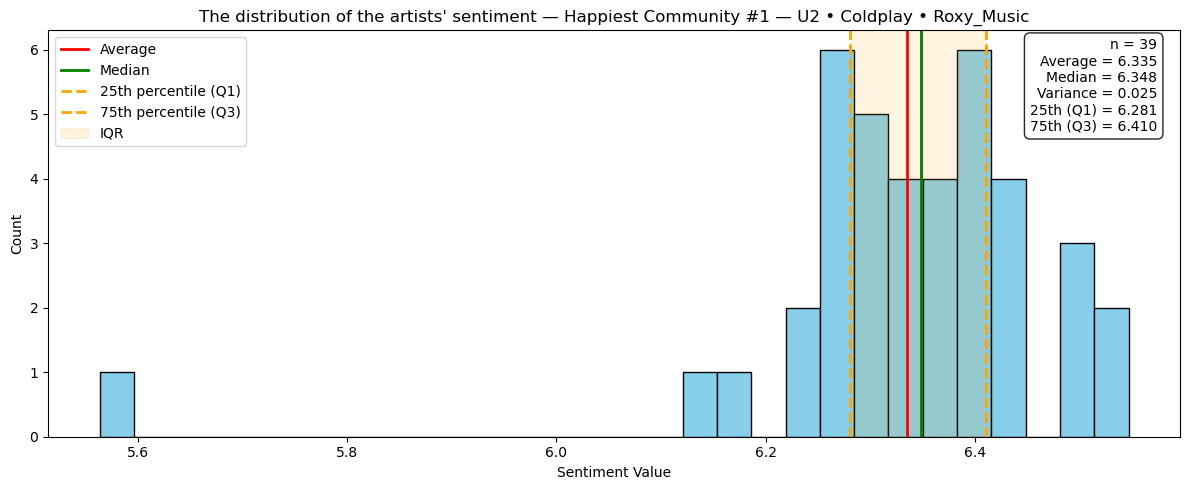

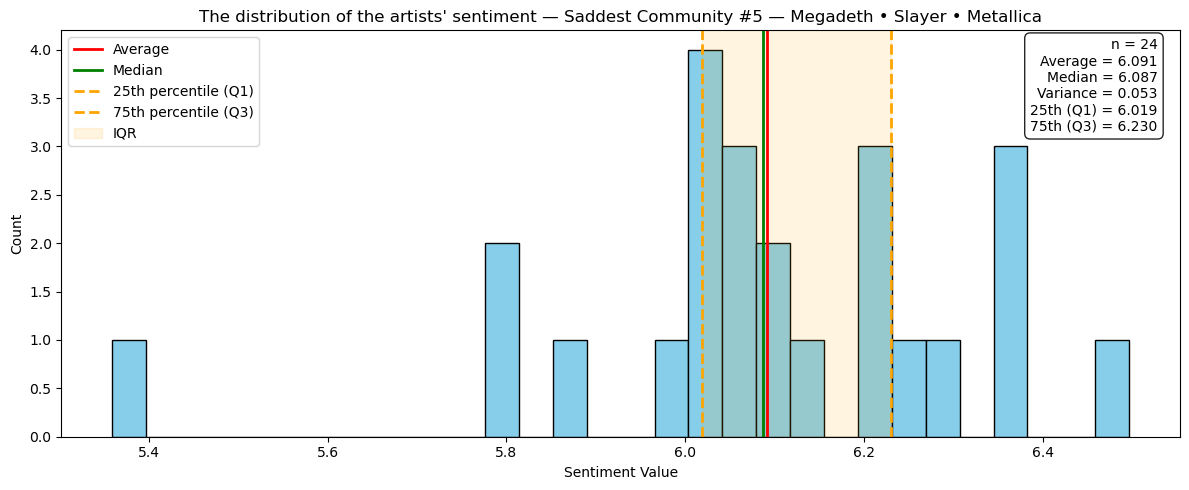

In [123]:
def comm_values(comm, sentiments):
    vals = [sentiments.get(n, math.nan) for n in comm]
    return [float(x) for x in vals if x is not None and not (isinstance(x, float) and math.isnan(x))]

def comm_mean_sent(comm, sentiments):
    vals = comm_values(comm, sentiments)
    return math.nan if not vals else sum(vals) / len(vals)


if 'stats' in globals() and stats:
    happy_idx = max(stats, key=lambda d: d['avg'])['idx']
    sad_idx   = min(stats, key=lambda d: d['avg'])['idx']
else:
    comm_avgs = [comm_mean_sent(c, sentiments) for c in top10]
    safe_max = [(-float('inf') if (isinstance(a, float) and math.isnan(a)) else a) for a in comm_avgs]
    safe_min = [( float('inf') if (isinstance(a, float) and math.isnan(a)) else a) for a in comm_avgs]
    happy_idx = int(np.argmax(safe_max))
    sad_idx   = int(np.argmin(safe_min))

def label_for(idx):
    base = f"Community #{idx}"
    if 'most_connected_bands' in globals():
        mc = most_connected_bands.get(idx, '')
        if mc:
            base += f" — {mc}"
    return base

for idx, which in [(happy_idx, "Happiest"), (sad_idx, "Saddest")]:
    vals = comm_values(top10[idx], sentiments)
    if not vals:
        print(f"{which} {label_for(idx)} has no valid sentiment values.")
        continue

    avg_sentiment  = float(np.mean(vals))
    median         = float(np.median(vals))
    variance       = float(np.var(vals, ddof=0))
    first_quartier = float(np.percentile(vals, 25))
    third_quartier = float(np.percentile(vals, 75))

    plt.figure(figsize=(12, 5))
    plt.hist(vals, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"The distribution of the artists' sentiment — {which} {label_for(idx)}")
    plt.xlabel("Sentiment Value")
    plt.ylabel("Count")

    plt.axvline(avg_sentiment, color="red", linewidth=2, label="Average")
    plt.axvline(median, color="green", linewidth=2, label="Median")
    plt.axvline(first_quartier, color="orange", linestyle="--", linewidth=2, label="25th percentile (Q1)")
    plt.axvline(third_quartier, color="orange", linestyle="--", linewidth=2, label="75th percentile (Q3)")
    plt.axvspan(first_quartier, third_quartier, color="orange", alpha=0.12, label="IQR")

    stats_txt = (
        f"n = {len(vals)}\n"
        f"Average = {avg_sentiment:.3f}\n"
        f"Median = {median:.3f}\n"
        f"Variance = {variance:.3f}\n"
        f"25th (Q1) = {first_quartier:.3f}\n"
        f"75th (Q3) = {third_quartier:.3f}"
    )
    plt.text(
        0.98, 0.98, stats_txt,
        transform=plt.gca().transAxes, ha="right", va="top",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.85)
    )

    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

**Image 4.2:
The Distribution of the Happiest Community's Sentiment**

- X-axis is the sentiment value.
- Y-axis is the number of artist pages with the given sentiment value.

**Image 4.3:
The Distribution of the Saddest Community's Sentiment**

- X-axis is the sentiment value.
- Y-axis is the number of artist pages with the given sentiment value.